# Backpropagation in Multilayer Neural Networks

While we will primarily be working with high-level, abstract toolkits like Keras in this course, understanding how backpropagation works is absolutely essential to using neural networks. 

In this exercise, we will build our own backpropagation algorithm - working through each step, to ensure that we can follow it.

Just like in Lab 1, we'll be working with the MNIST dataset. We will load it and plot an example:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

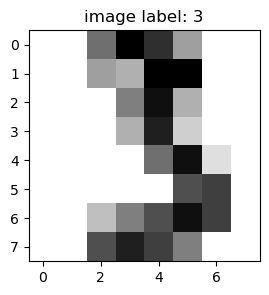

In [2]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

Of course, we need to split our data into training and testing sets before we use it, just the same as in Lab 1:

In [3]:
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement the softmax function $\sigma(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$;
- Implement the negative log likelihood function $NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}$;
- Train a logistic regression model on the MNIST dataset;
- Evaluate the model on the training and testing sets.

Before we get there, let's write a function that one-hot encodes the class labels:

In [4]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [5]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [6]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now we will implement the softmax function. Recall that the softmax function is defined as follows:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

This is implemented for you using numpy - we want to be able to apply the softmax function to a batch of samples at once, so we will use numpy's vectorized operations to do so.

Our method also handles _stability issues_ that can occur when the values in `X` are very large. We will subtract the maximum value from each row of `X` to avoid overflow in the exponentiation. This isn't part of the softmax function itself, but it's a useful trick to know about.

In [7]:
def softmax(X):
    X_max = np.max(X, axis=-1, keepdims=True)
    exp = np.exp(X - X_max)  # Subtract the max to avoid overflow in the exponentiation
    return exp / np.sum(exp, axis=-1, keepdims=True)

Let's make sure that this works one vector at a time (and check that the components sum to one):

In [8]:
print(softmax([10, 2, -3]))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]


When we are using our model to make predictions, we will want to be able to make predictions for multiple samples at once.
Let's make sure that our implementation of softmax works for a batch of samples:

In [9]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


Probabilities should sum to 1:

In [10]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [11]:
print("softmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

softmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [12]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Now we will implement a function that, given the true one-hot encoded class `Y_true` and some predicted probabilities `Y_pred`, returns the negative log likelihood.

Recall that the negative log likelihood is defined as follows:

$$
NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}
$$

For example, if we have $y_{true} = [1, 0, 0]$ and $y_{pred} = [0.99, 0.01, 0]$, then the negative log likelihood is $- \log(0.99) \approx 0.01$.

In [13]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)

    # Ensure Y_pred doesn't have zero probabilities to avoid log(0)
    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)

    # Calculate negative log likelihood
    loss = -np.sum(Y_true * np.log(Y_pred))
    return loss

# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.01005033585350145


We should see a very high value for this negative log likelihood, since the model is very confident that the third class is the correct one, but the true class is the first one:

In [14]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

4.605170185988091


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [15]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.010050335853503449


Now that we have our softmax and negative log likelihood functions, we can implement a logistic regression model. 
In this section, we have built the model for you, but you will need to complete a few key parts.

In [1]:
class LogisticRegression:
    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size), high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size, high=0.1, low=-0.1)
        self.output_size = output_size
        self.input_size = input_size
    
    def forward(self, X):
        Z = np.dot(X, self.W) + self.b
        print("Linear combination Z:", Z)  # Debugging statement
        softmax_output = softmax(Z)
        print("Softmax output:", softmax_output)  # Debugging statement
        return softmax_output
    
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
    
    def loss(self, X, y):
        y_true = one_hot(self.output_size, y)
        y_pred = self.forward(X)
        return nll(y_true, y_pred)
    
    def grad_loss(self, X, y_true, y_pred):
        grad_W = np.dot(X.T, (y_pred - y_true))
        grad_b = np.sum(y_pred - y_true, axis=0)
        return grad_W, grad_b

In [17]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

We can evaluate the model on an example, visualizing the prediction probabilities:

In [18]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(X_test[sample_idx:sample_idx+1].reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()
    


Linear combination Z: [-2.03423366  7.92267704  1.81631281  0.9938791  -5.09365073 -5.48632871
  3.95590603  4.71045753  2.24711037 -0.0401497 ]
Softmax output: [4.44543941e-05 9.37877395e-01 2.09019006e-03 9.18348152e-04
 2.08557947e-06 1.40827952e-06 1.77582149e-02 3.77656411e-02
 3.21572412e-03 3.26538472e-04]
Linear combination Z: [-2.03423366  7.92267704  1.81631281  0.9938791  -5.09365073 -5.48632871
  3.95590603  4.71045753  2.24711037 -0.0401497 ]
Softmax output: [4.44543941e-05 9.37877395e-01 2.09019006e-03 9.18348152e-04
 2.08557947e-06 1.40827952e-06 1.77582149e-02 3.77656411e-02
 3.21572412e-03 3.26538472e-04]


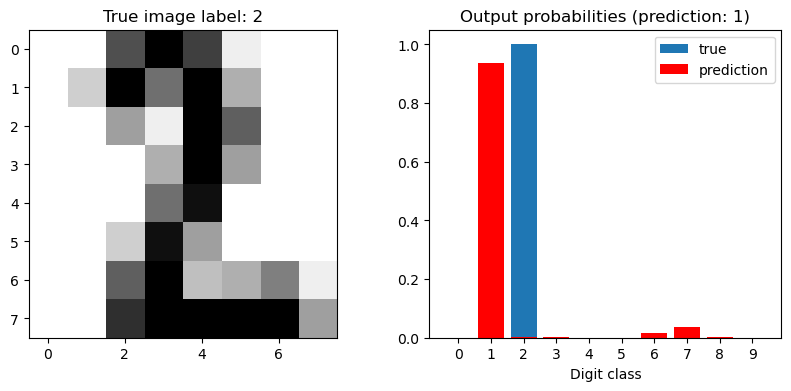

In [19]:
# Reinitialize the model and test the plot_prediction function again
lr = LogisticRegression(n_features, n_classes)
plot_prediction(lr, sample_idx=0)

Linear combination Z: [-2.03423366  7.92267704  1.81631281  0.9938791  -5.09365073 -5.48632871
  3.95590603  4.71045753  2.24711037 -0.0401497 ]
Softmax output: [4.44543941e-05 9.37877395e-01 2.09019006e-03 9.18348152e-04
 2.08557947e-06 1.40827952e-06 1.77582149e-02 3.77656411e-02
 3.21572412e-03 3.26538472e-04]
Linear combination Z: [-2.03423366  7.92267704  1.81631281  0.9938791  -5.09365073 -5.48632871
  3.95590603  4.71045753  2.24711037 -0.0401497 ]
Softmax output: [4.44543941e-05 9.37877395e-01 2.09019006e-03 9.18348152e-04
 2.08557947e-06 1.40827952e-06 1.77582149e-02 3.77656411e-02
 3.21572412e-03 3.26538472e-04]


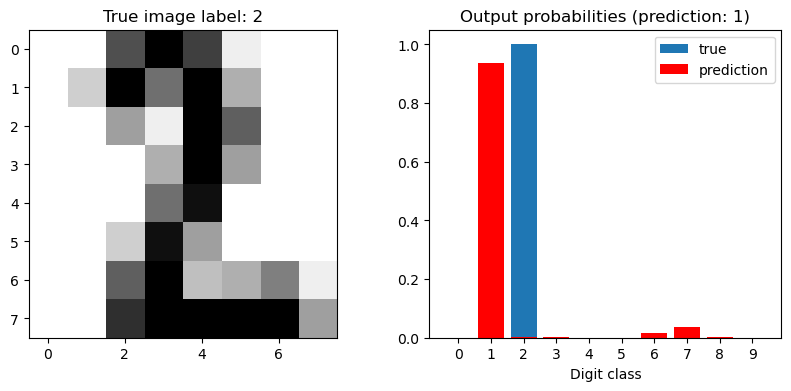

In [20]:
plot_prediction(lr, sample_idx=0)

Now it's time to start training! We will train for a single epoch, and then evaluate the model on the training and testing sets. Read through the following and make sure that you understand what we are doing here.

In [21]:
lr = LogisticRegression(input_size=X_train.shape[1], output_size=10)

learning_rate = 0.01

for i in range(len(X_train)):
    # Get the current sample and corresponding label
    x = X_train[i:i+1]  # Reshape to keep the batch dimension
    y = y_train[i:i+1]  # Reshape to keep the batch dimension

    # Compute the forward pass and the gradient of the loss with respect to W and b
    y_pred = lr.forward(x)
    grad_W, grad_b = lr.grad_loss(x, one_hot(lr.output_size, y), y_pred)

    # Update the weights and biases
    lr.W -= learning_rate * grad_W
    lr.b -= learning_rate * grad_b

    # Print the average negative log likelihood every 100 steps
    if i % 100 == 0:
        avg_nll = lr.loss(X_train[max(0, i-100):i], y_train[max(0, i-100):i])
        print("Average NLL over the last 100 samples at step %d: %0.f" % (i, avg_nll))


Linear combination Z: [[-3.48337898 -0.88761456  8.30097695  8.8731513   3.06264391  4.59763709
   0.89064564 -1.62896579 -2.51285059  1.08883849]]
Softmax output: [[2.71897454e-06 3.64528347e-05 3.56685861e-01 6.32088744e-01
  1.89368073e-03 8.78912879e-03 2.15784327e-04 1.73686698e-05
  7.17629474e-06 2.63083711e-04]]
Linear combination Z: []
Softmax output: []
Average NLL over the last 100 samples at step 0: -0
Linear combination Z: [[-4.51740262 -4.49668522 16.00333687 -6.99744997  2.28167493 -1.36880679
   0.19364009 -3.61829368 -2.28935564  4.66006516]]
Softmax output: [[1.22447627e-09 1.25010884e-09 9.99986871e-01 1.02536737e-10
  1.09837903e-06 2.85343621e-08 1.36122596e-07 3.00904320e-09
  1.13652471e-08 1.18487896e-05]]
Linear combination Z: [[ -0.88552502  -1.99008959  -1.57519392 -10.57981811   0.6876039
    0.11546075   1.54057532   1.82556783  -2.23924944  25.63722697]]
Softmax output: [[3.02911084e-12 1.00371143e-12 1.51983265e-12 1.86696928e-16
  1.46054982e-11 8.242097

Evaluate the trained model on the first example:

Linear combination Z: [-21.57787441  39.22607189 113.14309656  33.24049221 -69.23610094
 -47.06584172 -27.4457193   24.22701458 -45.50631941  22.44448249]
Softmax output: [3.10045699e-59 7.91123098e-33 1.00000000e+00 1.98948120e-35
 6.21900506e-80 2.64327380e-70 8.77107966e-62 2.42234637e-39
 1.25728602e-69 4.07466954e-40]
Linear combination Z: [-21.57787441  39.22607189 113.14309656  33.24049221 -69.23610094
 -47.06584172 -27.4457193   24.22701458 -45.50631941  22.44448249]
Softmax output: [3.10045699e-59 7.91123098e-33 1.00000000e+00 1.98948120e-35
 6.21900506e-80 2.64327380e-70 8.77107966e-62 2.42234637e-39
 1.25728602e-69 4.07466954e-40]


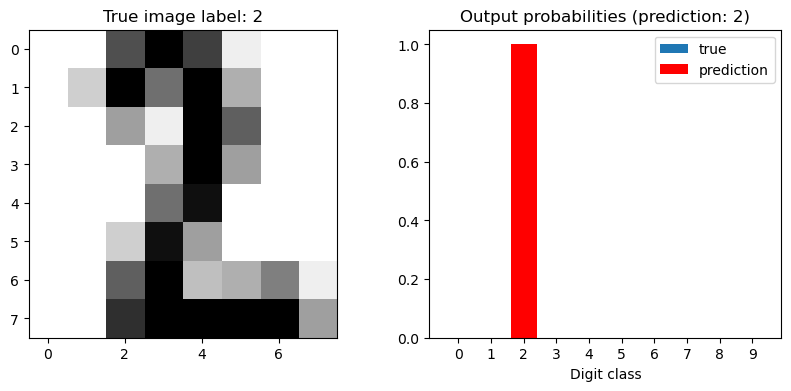

In [22]:
plot_prediction(lr, sample_idx=0)

## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

Now it's your turn to

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

Remember that you can use your `sigmoid` function inside your `dsigmoid` function.

Just like with our softmax function, we also want to make sure that we don't run into stability issues with our sigmoid function. We will use `np.clip` to ensure that the input to the sigmoid function is not too large or too small.

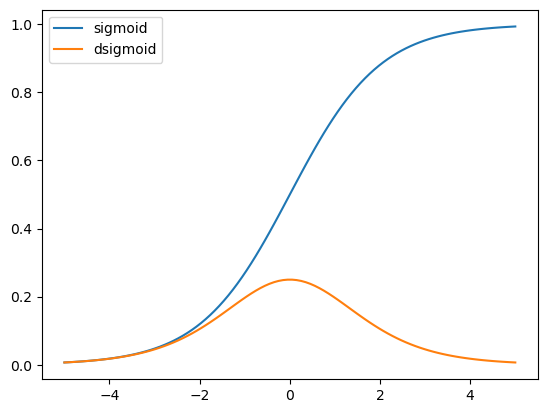

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(X):
    # Clip X to prevent overflow or underflow
    X = np.clip(X, -500, 500) # This ensures that np.exp(X) doesn't overflow
    return 1 / (1 + np.exp(-X))

def dsigmoid(X):
    sigmoid_X = sigmoid(X)
    return sigmoid_X * (1 - sigmoid_X)

# Plotting the functions
x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best')
plt.show()

Now it's your turn to complete the neural network code, so that we can train it on the MNIST dataset.

Some parts have been completed for you already. Often, you'll be able to refer back to the code from the previous section to help you complete the code in this section.

In [24]:
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        # Initializes the weights with random numbers
        self.W_h = np.random.uniform(size=(input_size, hidden_size),
                                     high=0.1, low=-0.1)
        self.b_h = np.random.uniform(size=hidden_size,
                                     high=0.1, low=-0.1)
        self.W_o = np.random.uniform(size=(hidden_size, output_size),
                                     high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size,
                                     high=0.1, low=-0.1)

        # Store the input size, hidden size and output size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def forward_hidden(self, X):
        # Compute the linear combination of the input and weights
        self.Z_h = np.dot(X, self.W_h) + self.b_h

        # Apply the sigmoid activation function
        return sigmoid(self.Z_h)

    def forward_output(self, H):
        # Compute the linear combination of the hidden layer activation and weights
        self.Z_o = np.dot(H, self.W_o) + self.b_o

        # Apply the sigmoid activation function
        return sigmoid(self.Z_o)

    def forward(self, X):
        # Compute the forward activations of the hidden and output layers
        H = self.forward_hidden(X)
        Y = self.forward_output(H)

        return Y

    def loss(self, X, y):
        y_onehot = one_hot(self.output_size, y)
        y_pred = self.forward(X)
        return nll(y_onehot, y_pred)

    def grad_loss(self, X, y_true):
        y_true = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)

        # Compute the error at the output layer
        error_o = y_pred - y_true

        # Compute the gradient of the loss with respect to W_o and b_o
        grad_W_o = np.dot(self.Z_h.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)

        # Compute the error at the hidden layer
        error_h = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h)

        # Compute the gradient of the loss with respect to W_h and b_h
        grad_W_h = np.dot(X.T, error_h)
        grad_b_h = np.sum(error_h, axis=0)

        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        # Ensure x is 2D
        x = x[np.newaxis, :]
        # Compute the gradient for the sample and update the weights
        grads = self.grad_loss(x, y)
    
        self.W_h -= learning_rate * grads["W_h"]
        self.b_h -= learning_rate * grads["b_h"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]
        
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

Once the code is written, we can test our model on a single sample:

In [25]:
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

In [26]:
model.loss(X_train, y_train)

1054.050985484983

In [27]:
model.accuracy(X_train, y_train)

0.07138179436804191

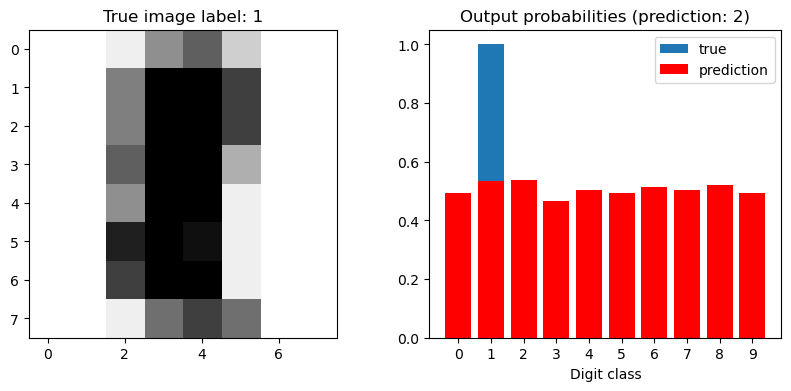

In [28]:
plot_prediction(model, sample_idx=5)

And now it's time to train!

In [29]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.001)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 1054.05099, train acc: 0.071, test acc: 0.067
Epoch #1, train loss: 3346.63043, train acc: 0.261, test acc: 0.219
Epoch #2, train loss: 2675.34353, train acc: 0.481, test acc: 0.459
Epoch #3, train loss: 2161.30717, train acc: 0.646, test acc: 0.574
Epoch #4, train loss: 1809.83145, train acc: 0.724, test acc: 0.696
Epoch #5, train loss: 1486.85327, train acc: 0.790, test acc: 0.778
Epoch #6, train loss: 1330.45846, train acc: 0.811, test acc: 0.815
Epoch #7, train loss: 1159.70125, train acc: 0.828, test acc: 0.841
Epoch #8, train loss: 975.64551, train acc: 0.861, test acc: 0.867
Epoch #9, train loss: 854.12021, train acc: 0.887, test acc: 0.889
Epoch #10, train loss: 755.13120, train acc: 0.905, test acc: 0.893
Epoch #11, train loss: 666.26491, train acc: 0.909, test acc: 0.893
Epoch #12, train loss: 645.98313, train acc: 0.916, test acc: 0.881
Epoch #13, train loss: 844.34799, train acc: 0.914, test acc: 0.870
Epoch #14, train loss: 606.74662, train acc: 0.

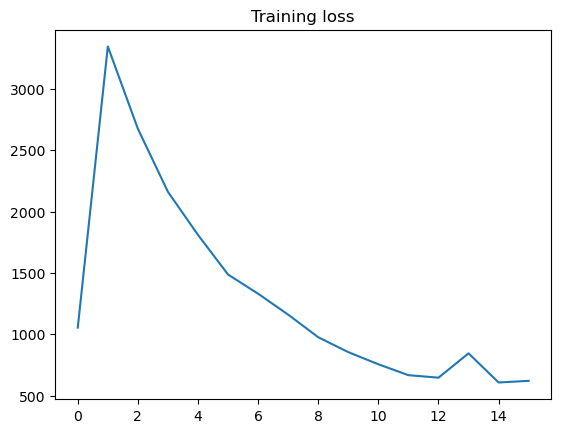

In [30]:
plt.plot(losses)
plt.title("Training loss");

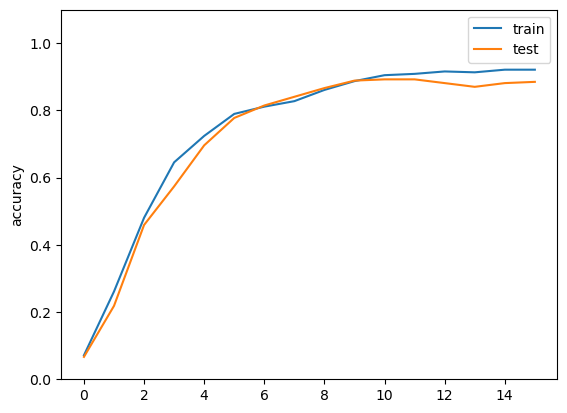

In [31]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

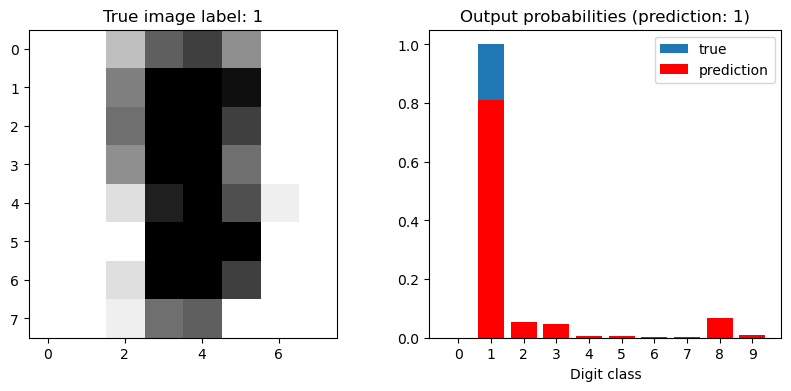

In [32]:
plot_prediction(model, sample_idx=4)

## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

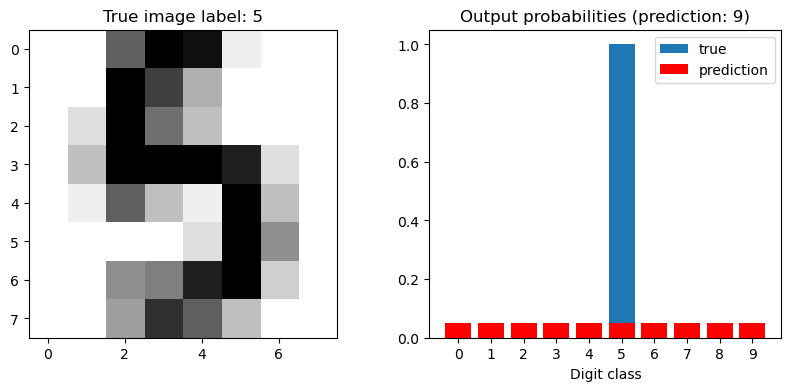

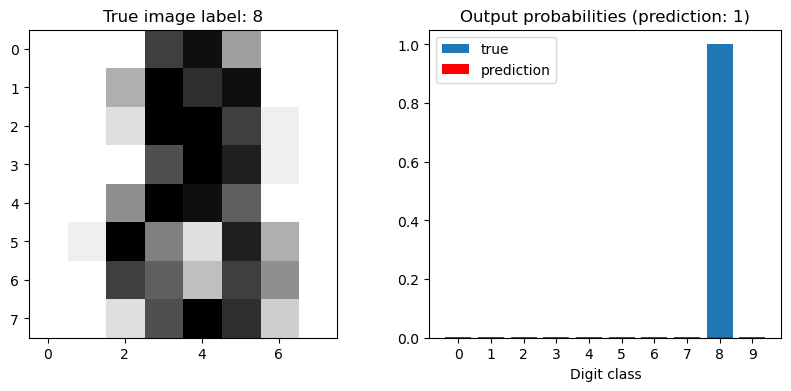

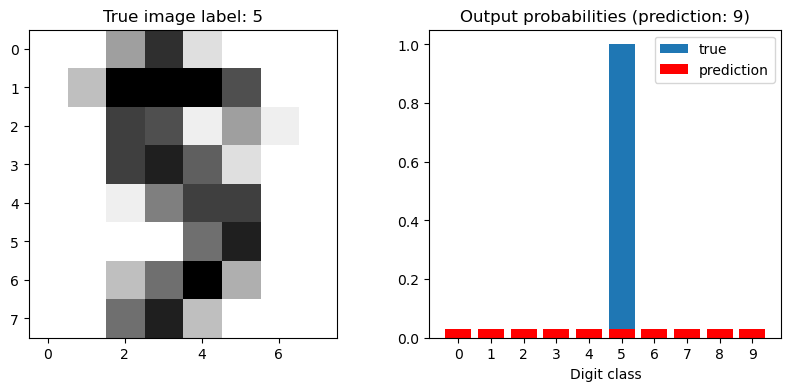

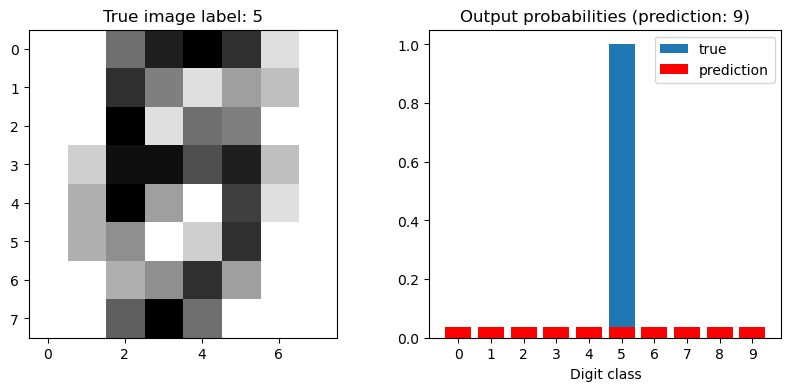

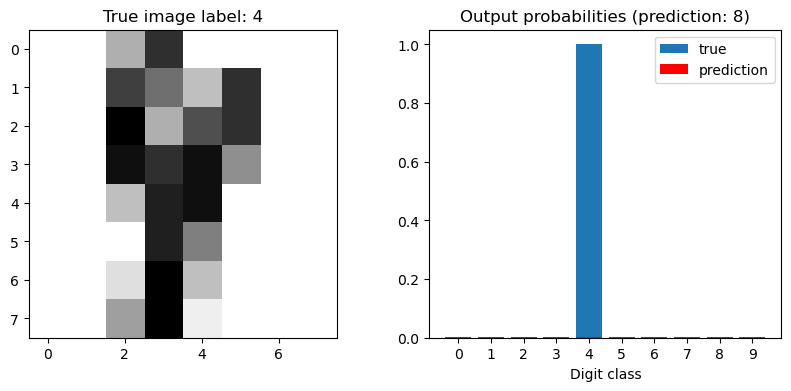

In [33]:
import matplotlib.pyplot as plt

def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(X_test[sample_idx:sample_idx+1].reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx])

    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx])[0], label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)' % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()

# Compute the model's predictions on the test set
y_pred = model.predict(X_test)

# Calculate the error for each prediction
errors = []
for i in range(len(y_test)):
    y_true = one_hot(model.output_size, y_test[i])
    y_pred_single = model.forward(X_test[i])
    error = nll(y_true, y_pred_single)
    errors.append(error)

# Identify the samples with the highest errors
worst_predictions = np.argsort(errors)[-5:] 

# Use the plot_prediction function to look at the model predictions on those samples
for idx in worst_predictions:
    plot_prediction(model, sample_idx=idx)
    plt.show()


### Hyper parameters settings

- Experiment with different hyperparameters:
  - learning rate,
  - size of hidden layer,
  - implement the support for a second hidden layer.
  - What is the best test accuracy you can get?

In [34]:
# Updated NeuralNet class with support for a second hidden layer:

class NeuralNet:
    """MLP with 2 hidden layers with a sigmoid activation"""

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        # Initializes the weights with random numbers
        self.W_h1 = np.random.uniform(size=(input_size, hidden_size1), high=0.1, low=-0.1)
        self.b_h1 = np.random.uniform(size=hidden_size1, high=0.1, low=-0.1)
        self.W_h2 = np.random.uniform(size=(hidden_size1, hidden_size2), high=0.1, low=-0.1)
        self.b_h2 = np.random.uniform(size=hidden_size2, high=0.1, low=-0.1)
        self.W_o = np.random.uniform(size=(hidden_size2, output_size), high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size, high=0.1, low=-0.1)

        # Store the sizes
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size

    def forward_hidden1(self, X):
        # Compute the linear combination of the input and weights
        self.Z_h1 = np.dot(X, self.W_h1) + self.b_h1
        return sigmoid(self.Z_h1)

    def forward_hidden2(self, H1):
        # Compute the linear combination of the first hidden layer and weights
        self.Z_h2 = np.dot(H1, self.W_h2) + self.b_h2
        return sigmoid(self.Z_h2)

    def forward_output(self, H2):
        # Compute the linear combination of the second hidden layer and weights
        self.Z_o = np.dot(H2, self.W_o) + self.b_o
        return sigmoid(self.Z_o)

    def forward(self, X):
        # Compute the forward activations of the hidden and output layers
        H1 = self.forward_hidden1(X)
        H2 = self.forward_hidden2(H1)
        Y = self.forward_output(H2)
        return Y

    def loss(self, X, y):
        y_onehot = one_hot(self.output_size, y)
        y_pred = self.forward(X)
        return nll(y_onehot, y_pred)

    def grad_loss(self, X, y_true):
        y_true = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)

        # Compute the error at the output layer
        error_o = y_pred - y_true

        # Compute the gradient of the loss with respect to W_o and b_o
        grad_W_o = np.dot(self.Z_h2.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)

        # Compute the error at the second hidden layer
        error_h2 = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h2)

        # Compute the gradient of the loss with respect to W_h2 and b_h2
        grad_W_h2 = np.dot(self.Z_h1.T, error_h2)
        grad_b_h2 = np.sum(error_h2, axis=0)

        # Compute the error at the first hidden layer
        error_h1 = np.dot(error_h2, self.W_h2.T) * dsigmoid(self.Z_h1)

        # Compute the gradient of the loss with respect to W_h1 and b_h1
        grad_W_h1 = np.dot(X.T, error_h1)
        grad_b_h1 = np.sum(error_h1, axis=0)

        return {"W_h1": grad_W_h1, "b_h1": grad_b_h1, "W_h2": grad_W_h2, "b_h2": grad_b_h2, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        # Ensure x is 2D
        x = x[np.newaxis, :]
        # Compute the gradient for the sample and update the weights
        grads = self.grad_loss(x, y)
    
        self.W_h1 -= learning_rate * grads["W_h1"]
        self.b_h1 -= learning_rate * grads["b_h1"]
        self.W_h2 -= learning_rate * grads["W_h2"]
        self.b_h2 -= learning_rate * grads["b_h2"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]
        
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)


In [35]:
#Train and evaluate the model with different hyperparameters

def train_model(model, X_train, y_train, learning_rate, epochs):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(zip(X_train, y_train)):
            model.train(x, y, learning_rate)
        if epoch % 10 == 0:
            train_loss = model.loss(X_train, y_train)
            train_accuracy = model.accuracy(X_train, y_train)
            print(f'Epoch {epoch}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}')

def evaluate_model(model, X_test, y_test):
    test_accuracy = model.accuracy(X_test, y_test)
    print(f'Test Accuracy: {test_accuracy:.4f}')
    return test_accuracy


In [36]:
# Experiment with hyperparameters
learning_rates = [0.01, 0.001]
hidden_sizes1 = [32, 64]
hidden_sizes2 = [16, 32]
epochs = 50

best_accuracy = 0
best_params = None

for lr in learning_rates:
    for hs1 in hidden_sizes1:
        for hs2 in hidden_sizes2:
            print(f'\nTraining model with learning_rate={lr}, hidden_size1={hs1}, hidden_size2={hs2}')
            model = NeuralNet(input_size=X_train.shape[1], hidden_size1=hs1, hidden_size2=hs2, output_size=10)
            train_model(model, X_train, y_train, learning_rate=lr, epochs=epochs)
            accuracy = evaluate_model(model, X_test, y_test)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = (lr, hs1, hs2)

print(f'Best Test Accuracy: {best_accuracy:.4f} with parameters learning_rate={best_params[0]}, hidden_size1={best_params[1]}, hidden_size2={best_params[2]}')



Training model with learning_rate=0.01, hidden_size1=32, hidden_size2=16
Epoch 0, Loss: 3422.3268, Accuracy: 0.1022
Epoch 10, Loss: 2601.8800, Accuracy: 0.3189
Epoch 20, Loss: 4118.9596, Accuracy: 0.1009
Epoch 30, Loss: 4139.2957, Accuracy: 0.1009
Epoch 40, Loss: 4176.5229, Accuracy: 0.1009
Test Accuracy: 0.1111

Training model with learning_rate=0.01, hidden_size1=32, hidden_size2=32
Epoch 0, Loss: 3336.9765, Accuracy: 0.2633
Epoch 10, Loss: 1673.2364, Accuracy: 0.6935
Epoch 20, Loss: 3071.0788, Accuracy: 0.3202
Epoch 30, Loss: 4056.6053, Accuracy: 0.1735
Epoch 40, Loss: 5073.6972, Accuracy: 0.1002
Test Accuracy: 0.1074

Training model with learning_rate=0.01, hidden_size1=64, hidden_size2=16
Epoch 0, Loss: 2179.1285, Accuracy: 0.6516
Epoch 10, Loss: 4973.3083, Accuracy: 0.1002
Epoch 20, Loss: 6949.1552, Accuracy: 0.1002
Epoch 30, Loss: 6945.8854, Accuracy: 0.1002
Epoch 40, Loss: 6934.5881, Accuracy: 0.1002
Test Accuracy: 0.1074

Training model with learning_rate=0.01, hidden_size1=6